In [20]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import diffxpy.api as de
import statsmodels.stats.multitest as multi
import pickle
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad(open("/nfs/team283/aa16/KR_NAS/data/CR_cells_AnnData.h5ad", "rb"))
adata2 = sc.read_h5ad(open("/nfs/team283/aa16/KR_NAS/data/CR_cells_19pcw+14pcw_AnnData_1.h5ad", "rb"))
adata.obs['Donor'] = [np.array(adata2.obs['Donor'].loc[adata.obs['Sample_ID'].iloc[i] == adata2.obs['Sample_ID']])[0] for i in range(len(adata.obs['Sample_ID']))]

In [3]:
adata.var_names = adata.var['SYMBOL']

In [4]:
adata = adata[adata.obs['Age'] == '19 pcw',:]
adata = adata[adata.obs['Pool'] == 'CRcells',:]

In [5]:
adata.obs['GeoLOD2.0_01'] = adata.obs['GeoLOD2.0_01'].astype(float)
detected = np.array([adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i] for i in range(len(adata.X[:,1]))])

Trying to set attribute `.obs` of view, copying.


In [6]:
adata.X = adata.layers['X_corrected_cc_cpm']
res = {}
count = 0
tissues = np.unique(adata.obs['Tissue'])
for i in range(len(tissues)):
    for j in range((i+1),len(tissues)):
        print(i)
        print(j)
        if i !=j:
            new_key = str(tissues[i]) + '_vs_' + str(tissues[j])
            subset_tissue_i = np.sum(detected[adata.obs['Tissue'] == tissues[i],:], axis = 0)/np.sum(adata.obs['Tissue'] == tissues[i]) > 0.8
            subset_tissue_j = np.sum(detected[adata.obs['Tissue'] == tissues[j],:], axis = 0)/np.sum(adata.obs['Tissue'] == tissues[j]) > 0.8
            print(new_key)
            adata_subset = adata[[x in (tissues[i], tissues[j]) for x in adata.obs['Tissue']],
                                 subset_tissue_i + subset_tissue_j]
            print(adata.shape)
            print(adata_subset.shape)
            res[new_key] = de.test.rank_test(
                data=adata_subset,
                grouping="Tissue",
                is_logged=False
            ).summary()
        
        tissue1 = tissues[i]
        tissue2 = tissues[j]
        
        if np.sum(np.array(res[new_key]['gene']) == np.array(adata_subset.var_names)) != len(adata_subset.var_names):
            raise ValueError()

        res[new_key]['log2_mean_' + tissue1] = np.array(np.log2(np.mean(adata_subset[adata_subset.obs['Tissue'] == tissue1,].X, axis = 0)))
        res[new_key]['log2_mean_' + tissue2] = np.array(np.log2(np.mean(adata_subset[adata_subset.obs['Tissue'] == tissue2,].X, axis = 0)))
        res[new_key]['log2_fold_change'] =  res[new_key]['log2_mean_' + tissue1] - res[new_key]['log2_mean_' + tissue2]

        subset1 = [adata_subset.obs['Tissue'].iloc[j] == tissue1 and adata_subset.obs['Donor'].iloc[j] == 'Hob7' for j in range(len(adata_subset.obs['Donor']))]
        subset2 = [adata_subset.obs['Tissue'].iloc[j] == tissue2 and adata_subset.obs['Donor'].iloc[j] == 'Hob7' for j in range(len(adata_subset.obs['Donor']))]
        res[new_key]['log2_mean_Hob7_' + tissue1] = np.array(np.log2(np.mean(adata_subset[subset1,].X, axis = 0)))
        res[new_key]['log2_mean_Hob7_' + tissue2] = np.array(np.log2(np.mean(adata_subset[subset2,].X, axis = 0)))
        res[new_key]['log2_fold_change_Hob7'] =  res[new_key]['log2_mean_Hob7_' + tissue1] - res[new_key]['log2_mean_Hob7_' + tissue2]

        print((adata_subset[subset1,].obs['Tissue'].astype(str) + ' ' + adata_subset[subset1,].obs['Pool'].astype(str)
     + ' ' + adata_subset[subset1,].obs['Donor'].astype(str)).value_counts())
        print((adata_subset[subset2,].obs['Tissue'].astype(str) + ' ' + adata_subset[subset2,].obs['Pool'].astype(str)
     + ' ' + adata_subset[subset2,].obs['Donor'].astype(str)).value_counts())

        subset1 = [adata_subset.obs['Tissue'].iloc[j] == tissue1 and adata_subset.obs['Donor'].iloc[j] == 'Hob8' for j in range(len(adata_subset.obs['Donor']))]
        subset2 = [adata_subset.obs['Tissue'].iloc[j] == tissue2 and adata_subset.obs['Donor'].iloc[j] == 'Hob8' for j in range(len(adata_subset.obs['Donor']))]
        res[new_key]['log2_mean_Hob8_' + tissue1] = np.array(np.log2(np.mean(adata_subset[subset1,].X, axis = 0)))
        res[new_key]['log2_mean_Hob8_' + tissue2] = np.array(np.log2(np.mean(adata_subset[subset2,].X, axis = 0)))
        res[new_key]['log2_fold_change_Hob8'] =  res[new_key]['log2_mean_Hob8_' + tissue1] - res[new_key]['log2_mean_Hob8_' + tissue2]

        print((adata_subset[subset1,].obs['Tissue'].astype(str) + ' ' + adata_subset[subset1,].obs['Pool'].astype(str)
     + ' ' + adata_subset[subset1,].obs['Donor'].astype(str)).value_counts())
        print((adata_subset[subset2,].obs['Tissue'].astype(str) + ' ' + adata_subset[subset2,].obs['Pool'].astype(str)
     + ' ' + adata_subset[subset2,].obs['Donor'].astype(str)).value_counts())

        res[new_key] = res[new_key].sort_values('pval')
    
res_naive = res

0
1
Foetal brain (frontal lobe)_vs_Foetal brain (occipital lobe)
(74, 18677)
(38, 1940)
Foetal brain (frontal lobe) CRcells Hob7    6
dtype: int64
Foetal brain (occipital lobe) CRcells Hob7    12
dtype: int64
Foetal brain (frontal lobe) CRcells Hob8    12
dtype: int64
Foetal brain (occipital lobe) CRcells Hob8    8
dtype: int64
0
2
Foetal brain (frontal lobe)_vs_Foetal brain (parietal lobe)
(74, 18677)
(34, 1446)
Foetal brain (frontal lobe) CRcells Hob7    6
dtype: int64
Foetal brain (parietal lobe) CRcells Hob7    7
dtype: int64
Foetal brain (frontal lobe) CRcells Hob8    12
dtype: int64
Foetal brain (parietal lobe) CRcells Hob8    9
dtype: int64
0
3
Foetal brain (frontal lobe)_vs_Foetal brain (temporal lobe)
(74, 18677)
(38, 1287)
Foetal brain (frontal lobe) CRcells Hob7    6
dtype: int64
Foetal brain (temporal lobe) CRcells Hob7    10
dtype: int64
Foetal brain (frontal lobe) CRcells Hob8    12
dtype: int64
Foetal brain (temporal lobe) CRcells Hob8    10
dtype: int64
1
2
Foetal brain

/nfs/team283/aa16/software/miniconda3/envs/countcorrect/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log2


Plot top genes in occipital-frontal comparison:

In [7]:
res[list(res.keys())[0]].loc[[res[list(res.keys())[0]]['qval'].iloc[i] < 0.05 and res[list(res.keys())[0]]['log2fc'].iloc[i] > 1
 for i in range(len(res[list(res.keys())[0]]['log2fc']))]].to_csv('test.csv')

In [23]:
genesOfInterest = np.array(res[list(res.keys())[0]].loc[[res[list(res.keys())[0]]['qval'].iloc[i] < 0.05 and res[list(res.keys())[0]]['log2fc'].iloc[i] > 1
 for i in range(len(res[list(res.keys())[0]]['log2fc']))]]['gene'])[:10]

In [24]:
genesOfInterest

array(['PTPN11', 'ZEB1', 'BACH1', 'NR2F2', 'PLD1', 'NR2F1', 'CENPB',
       'CAMK4', 'CHD7', 'KLHL13'], dtype=object)

Trying to set attribute `.obs` of view, copying.
/nfs/team283/aa16/software/miniconda3/envs/countcorrect/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


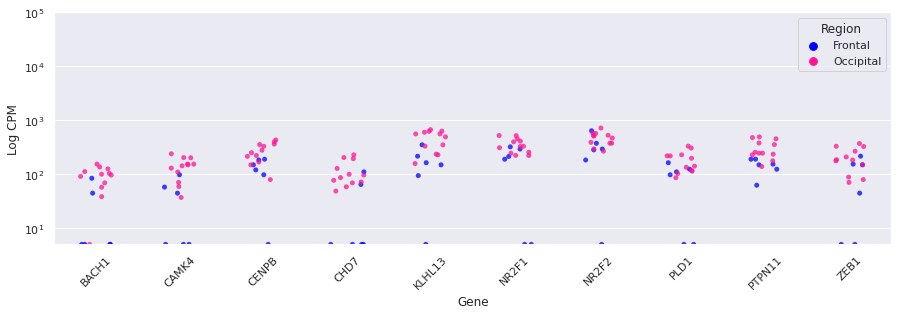

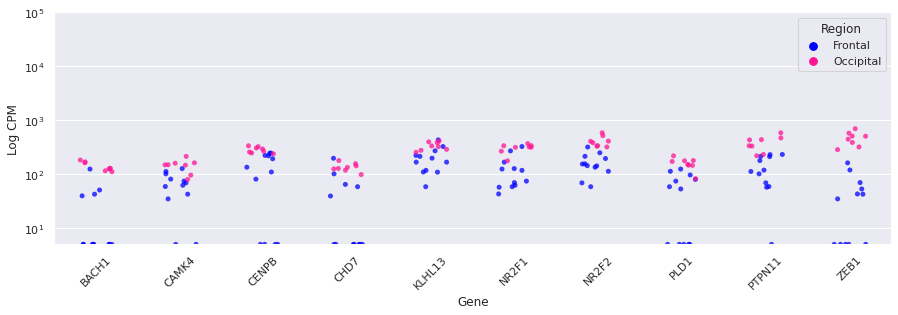

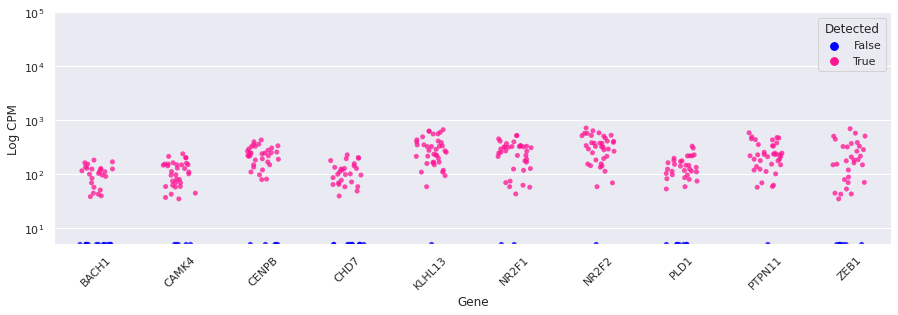

In [34]:
adata.obs['GeoLOD2.0_01'] = adata.obs['GeoLOD2.0_01'].astype(float)
adata.obs['Tissue'] = adata.obs['Tissue'].astype(str)
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (occipital lobe)'] = 'Occipital'
adata.obs['Tissue'].loc[adata.obs['Tissue'] == 'Foetal brain (frontal lobe)'] = 'Frontal'
adata = adata[[adata.obs['Tissue'].iloc[i] in ('Occipital', 'Frontal') for i in range(len(adata.obs['Tissue']))],:]
geneNames = adata.var_names[[g in genesOfInterest for g in adata.var_names]]
counts_cpm = adata.layers['X_corrected_cc_cpm'][:,[g in genesOfInterest for g in adata.var_names]]
detected = np.array([adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i] for i in range(len(adata.X[:,1]))])[:,[g in genesOfInterest for g in adata.var_names]]
regions  = adata.obs['Tissue']
donor = adata.obs['Donor']
tab = pd.DataFrame(index = range(np.prod(np.shape(counts_cpm))), columns = ('gene', 'counts', 'Region', 'Detected', 'Donor'))
n_genes = np.shape(counts_cpm)[1]
n_samples = np.shape(counts_cpm)[0]
for i in range(len(geneNames)):
    tab.iloc[(i*n_samples):((i+1)*n_samples),0] = geneNames[i]
    tab.iloc[(i*n_samples):((i+1)*n_samples),1] = counts_cpm[:,i] + 5
    tab.iloc[(i*n_samples):((i+1)*n_samples),2] = regions
    tab.iloc[(i*n_samples):((i+1)*n_samples),3] = detected[:,i]
    tab.iloc[(i*n_samples):((i+1)*n_samples),4] = donor
import seaborn as sns
sns.set(rc={'figure.figsize':(15,4.27)})
sns.stripplot(x="gene", y="counts", hue="Region", data=tab.loc[tab['Donor'] == 'Hob7',:], alpha = 0.75, jitter=0.2, palette = ('blue', 'deeppink'))
plt.yscale('log')
plt.ylabel('Log CPM')
plt.xlabel('Gene')
plt.ylim(5, 10**5)
plt.xticks(rotation=45)
plt.show()
import seaborn as sns
sns.set(rc={'figure.figsize':(15,4.27)})
sns.stripplot(x="gene", y="counts", hue="Region", data=tab.loc[tab['Donor'] == 'Hob8',:], alpha = 0.75, jitter=0.2, palette = ('blue', 'deeppink'))
plt.yscale('log')
plt.ylabel('Log CPM')
plt.xlabel('Gene')
plt.ylim(5, 10**5)
plt.xticks(rotation=45)
plt.show()
sns.set(rc={'figure.figsize':(15,4.27)})
sns.stripplot(x="gene", y="counts", hue="Detected", data=tab, alpha = 0.75, jitter=0.2, palette = ('blue', 'deeppink'))
plt.yscale('log')
plt.ylabel('Log CPM')
plt.xlabel('Gene')
plt.ylim(5, 10**5)
plt.xticks(rotation=45)
plt.show()

In [33]:
tab

,gene,counts,Region,Detected,Donor
0,BACH1,42.530495,Frontal,True,Hob8
1,BACH1,5.0,Frontal,False,Hob8
2,BACH1,5.0,Frontal,False,Hob8
3,BACH1,50.769208,Frontal,True,Hob8
4,BACH1,124.161108,Frontal,True,Hob8
...,...,...,...,...,...
375,ZEB1,185.387578,Occipital,True,Hob7
376,ZEB1,265.922214,Occipital,True,Hob7
377,ZEB1,324.969287,Occipital,True,Hob7
378,ZEB1,182.610433,Occipital,True,Hob7


In [8]:
# pickle.dump(res_naive, open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_pairwiseDE_naive_1.p", "wb" ))

Save all data on pairwise differential expression in CR cells in one data frame:

In [9]:
# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cell_DE_results.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# for i in range(len(allResults)):
#     allResults[i].to_excel(writer, sheet_name=key_wta_array[i].split('Foetal brain')[1].split('lobe')[0].split('(')[1]
#                            + 'vs '
#                            + key_wta_array[i].split('Foetal brain')[2].split('lobe')[0].split('(')[1])

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()